# MODEL RANDOM FOREST DENGAN BAYESIAN OPTIMIZATION HYPERPARAMETER TUNING (BO-RF) UNTUK ANALISIS PERGERAKAN DAN PREDIKSI HARGA SAHAM

## IMPORT LIBRARY

In [55]:
# Install Library yang dibutuhkan
#%pip install TA-Lib
#%pip install bayesian-optimization

In [56]:
# Library
import pandas as pd
import numpy as np
from warnings import filterwarnings

# Grafik dan Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns 

# Indikator Teknikal Saham
import talib

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score

filterwarnings('ignore')
plt.rcParams['font.size'] = 14

## DATA COLLECTION

In [57]:
def data_collection(path_data):
    print('--- Proses Data Collection ---')    
    # Memasukkan data olahan harga saham harian
    try:
        df = pd.read_excel(path_data, parse_dates=['Date'], index_col='Date')
        print(f'Data berhasil dikoleksi dari {path_data}')
    except Exception as e:
        print(f'Error dalam koleksi data: {e}')
        return None
    
    # Inspeksi data awal
    print('Ukuran data:', df.shape)
    print('Lima data teratas:')
    display(df.head(5))
    print('Informasi umum data:')
    df.info()
    
    return df

## DATA PREPARATION

In [58]:
def data_augmentation(df):
    return df

def feature_engineering(df_awal):
    df_fitur = pd.DataFrame(index=df_awal.index)
    
    df_fitur['Intraday_Range'] = df_awal['High'] - df_awal['Low'] 
    df_fitur['Intraday_Change'] = df_awal['Close'] - df_awal['Open'] 
    df_fitur['MA_5'] = talib.MA(df_awal['Close'], timeperiod=5) 
    df_fitur['MA_10'] = talib.MA(df_awal['Close'], timeperiod=10) 
    df_fitur['RSI_7'] = talib.RSI(df_awal['Close'], timeperiod=7) 
    df_fitur['RSI_14'] = talib.RSI(df_awal['Close'], timeperiod=14) 
    df_fitur['MOM_10'] = talib.MOM(df_awal['Close'], timeperiod=10) 
    df_fitur['ROC_10'] = talib.ROC(df_awal['Close'], timeperiod=10) 
    df_fitur['ATR_14'] = talib.ATR(df_awal['High'], df_awal['Low'], df_awal['Close'], timeperiod=14) 
    df_fitur['Volatility_10'] = df_awal['Close_Diff'].rolling(window=10).std() 
    
    df_fitur['Open_t-1'] = df_awal['Open'].shift(1) 
    df_fitur['High_t-1'] = df_awal['High'].shift(1) 
    df_fitur['Low_t-1'] = df_awal['Low'].shift(1) 
    df_fitur['Close_t-1'] = df_awal['Close'].shift(1) 
    
    if 'Volume_Log' in df_awal.columns:
        df_fitur['Volume_Log_t-1'] = df_awal['Volume_Log'].shift(1)
    
    df_fitur['Close_Diff_t-1'] = df_awal['Close_Diff'].shift(1) 
    
    df_fitur['Intraday_Range_t-1'] = df_fitur['Intraday_Range'].shift(1) 
    df_fitur['Intraday_Change_t-1'] = df_fitur['Intraday_Change'].shift(1) 
    df_fitur['MA_5_t-1'] = df_fitur['MA_5'].shift(1) 
    df_fitur['MA_10_t-1'] = df_fitur['MA_10'].shift(1) 
    df_fitur['RSI_7_t-1'] = df_fitur['RSI_7'].shift(1) 
    df_fitur['RSI_14_t-1'] = df_fitur['RSI_14'].shift(1) 
    df_fitur['MOM_10_t-1'] = df_fitur['MOM_10'].shift(1) 
    df_fitur['ROC_10_t-1'] = df_fitur['ROC_10'].shift(1) 
    df_fitur['ATR_14_t-1'] = df_fitur['ATR_14'].shift(1) 
    df_fitur['Volatility_10_t-1'] = df_fitur['Volatility_10'].shift(1) 

    df_fitur['Year'] = df_fitur.index.year 
    df_fitur['Month'] = df_fitur.index.month 
    df_fitur['Week'] = df_fitur.index.isocalendar().week.astype(float) 
    df_fitur['DayOfWeek'] = df_fitur.index.dayofweek 
    df_fitur['DayOfMonth'] = df_fitur.index.day 
    df_fitur['DayOfYear'] = df_fitur.index.dayofyear 
    df_fitur['Quarter'] = df_fitur.index.quarter 
    df_fitur['IsMonthStart'] = df_fitur.index.is_month_start.astype(int) 
    df_fitur['IsMonthEnd'] = df_fitur.index.is_month_end.astype(int) 

    df_fitur.dropna(inplace=True)
    return df_fitur

def data_preparation(df):
    print('--- Proses Data Preparation ---')
    df_prep = df.copy()
    
    # Data Cleaning & Data Transformation
    if 'Volume' in df_prep.columns:
        df_prep['Volume'] = df_prep['Volume'].ffill().fillna(0)
        df_prep['Volume_Log'] = np.log1p(df_prep['Volume'])
        df_prep = df_prep.drop('Volume', axis=1)
        
    df_prep['Close_Diff'] = df_prep['Close'].diff()
    
    # Feature Engineering
    df_fitur = feature_engineering(df_prep)
    
    # Data Augmentation
    df_keseluruhan = pd.concat([df_prep, df_fitur], axis=1)
    df_keseluruhan.dropna(inplace=True)
    df_keseluruhan = data_augmentation(df_keseluruhan)

    # Feature Selection & Data Splitting
    variabel_input = [col for col in df_keseluruhan.columns if col not in['Open', 'High', 'Low', 'Volume_Log', 'Close', 'Close_Diff',
                                                                  'Intraday_Range', 'Intraday_Change', 'MA_5', 'MA_10', 'RSI_7',
                                                                  'RSI_14', 'MOM_10', 'ROC_10', 'ATR_14', 'Volatility_10',
                                                                  'Open_t-1', 'High_t-1', 'Low_t-1', 'RSI_14_t-1', 'MA_10_t-1',
                                                                  'ROC_10_t-1']]
    
    X = df_keseluruhan[variabel_input]
    y = df_keseluruhan['Close_Diff']
    
    train_size = int(len(df_keseluruhan) * 0.8)
    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[train_size:]

    print(f'Dimensi X_train: {X_train.shape}')
    print(f'Dimensi X_test: {X_test.shape}')
    print(f'Dimensi y_train: {y_train.shape}')
    print(f'Dimensi y_test: {y_test.shape}')
    
    return X_train, y_train, X_test, y_test, df_keseluruhan, variabel_input  

## MODEL DEVELOPMENT

In [59]:
def model_development(X_train, y_train):
    print('--- Proses Model Development ---')
    
    pbounds = {'n_estimators': (200, 1000),
               'max_depth': (5, 50),
               'min_samples_leaf': (1, 15),
               'min_samples_split': (2, 20),
               'max_features': (0.1, 1.0)}

    def rf_cv_score(n_estimators, max_depth, min_samples_leaf, max_features, min_samples_split):
        try:
            n_estimators = int(n_estimators)
            max_depth = int(max_depth)
            min_samples_leaf = int(min_samples_leaf)
            min_samples_split = int(min_samples_split)

            model = RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          max_features=max_features,
                                          min_samples_split=min_samples_split,
                                          random_state=42,
                                          n_jobs=1)
            
            tscv = TimeSeriesSplit(n_splits=5)
            scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=1)
            return np.mean(scores)

        except Exception as e:
            print(f"Error: {e}")
            return -1e9 

    optimizer = BayesianOptimization(f=rf_cv_score, pbounds=pbounds, random_state=42, verbose=2)
    optimizer.maximize(init_points=5, n_iter=50)

    best_params = optimizer.max['params']
    best_params_formatted = {'n_estimators': int(best_params['n_estimators']),
                             'max_depth': int(best_params['max_depth']),
                             'min_samples_leaf': int(best_params['min_samples_leaf']),
                             'min_samples_split': int(best_params['min_samples_split']),
                             'max_features': best_params['max_features']}

    print(f'Best Hyperparameters: {best_params_formatted}')

    best_rf_model = RandomForestRegressor(**best_params_formatted, random_state=42, n_jobs=1)
    best_rf_model.fit(X_train, y_train)
    
    return best_rf_model   

## MODEL EVALUATION

In [60]:
def model_evaluation(model, X_test, y_test):
    print('--- Proses Model Evaluation ---')
    
    y_pred_arr = model.predict(X_test)
    y_pred = pd.Series(y_pred_arr, index=X_test.index, name='Pred_Close_Diff')
    
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print('RMSE:', rmse)
    print('MAE:', mae)
    print('R-squared:', r2)
    
    plt.figure(figsize=(12, 8))
    plt.plot(y_test.index, y_test, label='Close_Diff Aktual', color='blue')
    plt.plot(y_test.index, y_pred, label='Hasil Prediksi Close_Diff (BO-RF)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close_Diff')
    plt.legend()
    plt.show()
    
    # Feature Importance dalam Model BO-RF
    importances = pd.Series(model.feature_importances_, index=variabel_input)
    importances_sorted = importances.sort_values(ascending=False)
    
    plt.figure(figsize=(10, 10))
    ax = sns.barplot(x=importances_sorted.values, y=importances_sorted.index, palette="viridis")
    for i, v in enumerate(importances_sorted.values):
        ax.text(v + 0.001, i, f"{v:.4f}", color='black', va='center')
    plt.title("Feature Importance")
    plt.show()
    
    return y_pred

## MODEL POSTPROCESSING

In [61]:
def model_postprocessing(model, X_test, y_pred, df_keseluruhan, variabel_input):
    print('--- Proses Model Post-Processing ---')
     
    # Inversi ke skala harga penutupan 'Close' 
    close_t_minus_1_test = df_keseluruhan.loc[X_test.index, 'Close_t-1']
    close_actual_test = df_keseluruhan.loc[X_test.index, 'Close']
    pred_close = close_t_minus_1_test + y_pred
    
    hasil_df = pd.DataFrame({'Close': close_actual_test,
                             'Close_t-1': close_t_minus_1_test,
                             'Pred_Close_Diff': y_pred,
                             'Pred_Close': pred_close},
                            index=X_test.index)
    
    # Metrik Evaluasi terhadap data terinversi
    rmse_new = root_mean_squared_error(hasil_df['Close'], hasil_df['Pred_Close'])
    mae_new = mean_absolute_error(hasil_df['Close'], hasil_df['Pred_Close'])
    mape_new = mean_absolute_percentage_error(hasil_df['Close'], hasil_df['Pred_Close'])
    r_squared_new = r2_score(hasil_df['Close'], hasil_df['Pred_Close'])
    
    print('RMSE (Terinversi):', rmse_new)
    print('MAE (Terinversi):', mae_new)
    print('MAPE (Terinversi):', mape_new)
    print('R-squared (Terinversi):', r_squared_new)
    
    # Visualisasi data aktual dan data terinversi
    plt.figure(figsize=(12, 8))
    plt.plot(hasil_df.index, hasil_df['Close'], label='Actual Close', color='blue')
    plt.plot(hasil_df.index, hasil_df['Pred_Close'], label='Predicted Close (BO-RF)', color='red', linestyle='--')
    plt.title("Actual vs Predicted Close Price")
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()
    
    display(hasil_df.head(10))
    return hasil_df

## MAIN FLOW

--- Proses Data Collection ---
Data berhasil dikoleksi dari D:\file\[KULIAHAN]\SKRIPSI\Resources\Data Olahan\BBCA_01102019_01102025.xlsx
Ukuran data: (1447, 5)
Lima data teratas:


,Open,High,Low,Close,Volume
Date,,,,,
2019-10-01,5212.767129,5260.471321,5212.767129,5238.787598,40057000.0
2019-10-02,5212.767466,5264.808406,5212.767466,5247.461426,52376500.0
2019-10-03,5212.767129,5243.124342,5160.726193,5238.787598,50269000.0
2019-10-04,5186.746829,5260.471491,5186.746829,5243.124512,56890500.0
2019-10-07,5264.808105,5273.481595,5247.461127,5264.808105,56705500.0


Informasi umum data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447 entries, 2019-10-01 to 2025-09-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1447 non-null   float64
 1   High    1447 non-null   float64
 2   Low     1447 non-null   float64
 3   Close   1447 non-null   float64
 4   Volume  1445 non-null   float64
dtypes: float64(5)
memory usage: 67.8 KB
--- Proses Data Preparation ---
Dimensi X_train: (1145, 19)
Dimensi X_test: (287, 19)
Dimensi y_train: (1145,)
Dimensi y_test: (287,)
--- Proses Model Development ---
|   iter    |  target   | n_esti... | max_depth | min_sa... | min_sa... | max_fe... |
-------------------------------------------------------------------------------------
| 1         | -100.6624 | 499.63209 | 47.782143 | 11.247915 | 12.775852 | 0.2404167 |
| 2         | -101.3908 | 324.79561 | 7.6137625 | 13.126466 | 12.820070 | 0.7372653 |
| 3         | -100.9022 | 216.46759 | 48.645

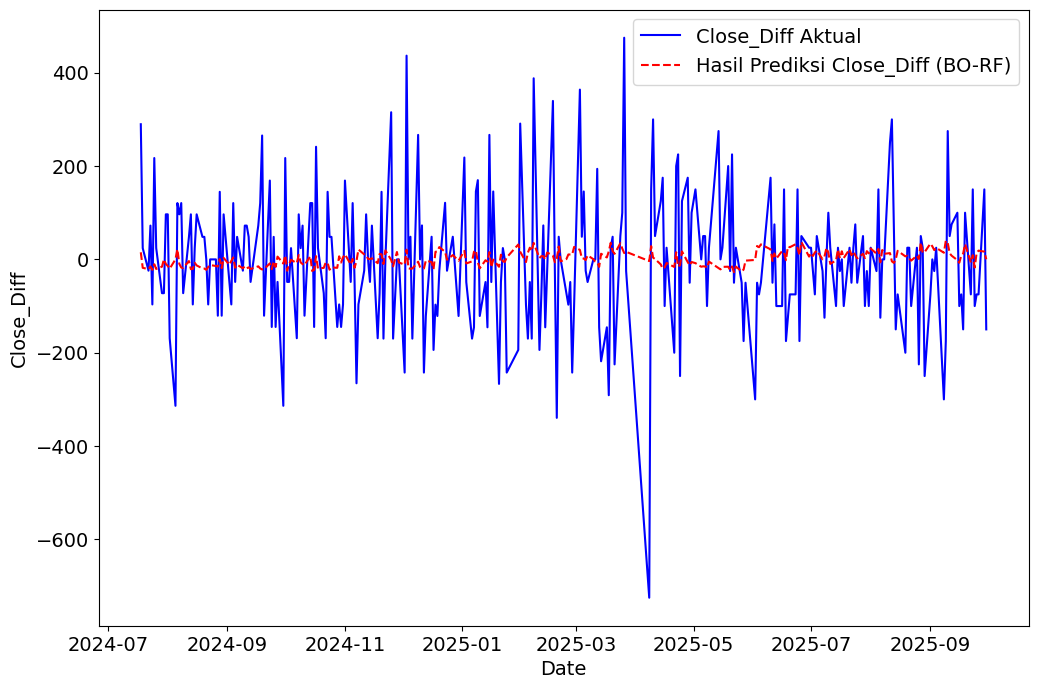

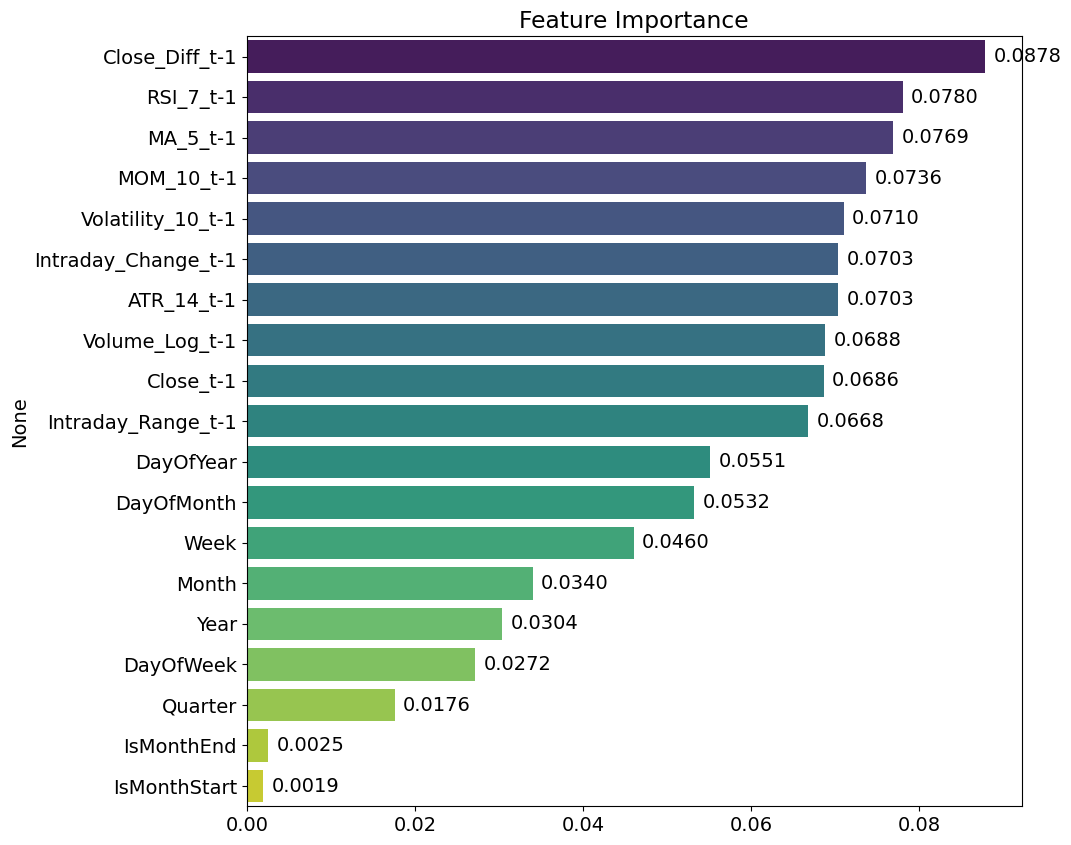

--- Proses Model Post-Processing ---
RMSE (Terinversi): 145.32464472208116
MAE (Terinversi): 111.37879057104506
MAPE (Terinversi): 0.01230504613385758
R-squared (Terinversi): 0.9633985860557127


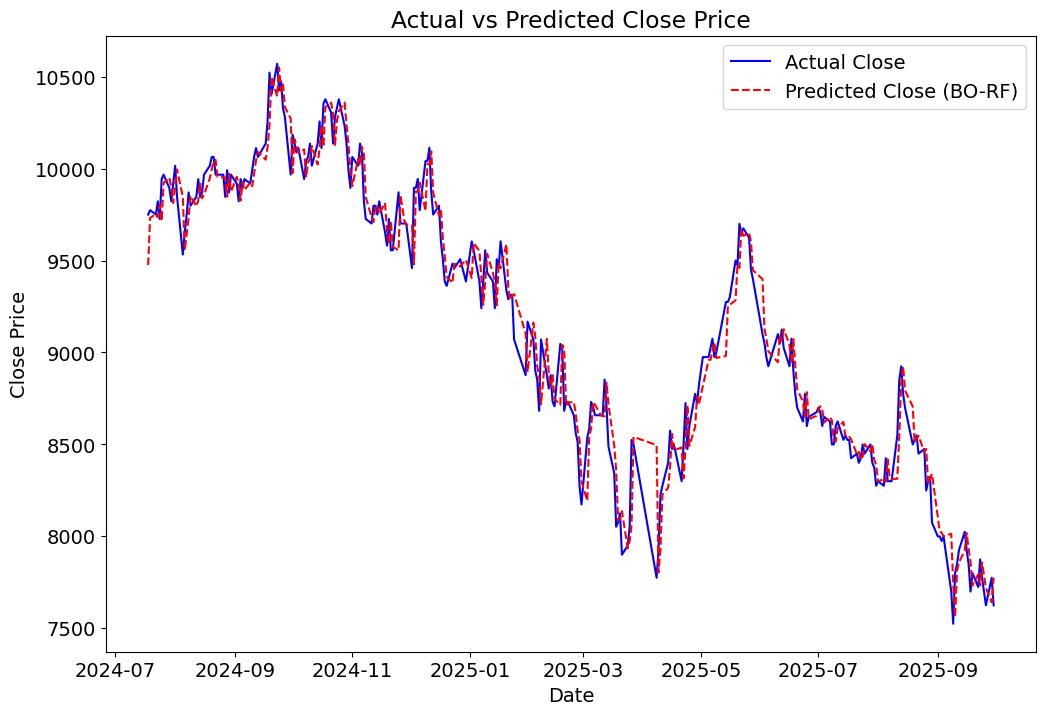

,Close,Close_t-1,Pred_Close_Diff,Pred_Close
Date,,,,
2024-07-18,9749.879883,9460.279297,15.181230,9475.460527
2024-07-19,9774.013672,9749.879883,-18.090978,9731.788905
2024-07-22,9749.879883,9774.013672,-20.884219,9753.129453
2024-07-23,9822.280273,9749.879883,-15.104390,9734.775493
2024-07-24,9725.746094,9822.280273,-22.214779,9800.065494
2024-07-25,9942.946289,9725.746094,-10.442897,9715.303197
2024-07-26,9967.080078,9942.946289,-20.506522,9922.439767
2024-07-29,9894.679688,9967.080078,-15.591789,9951.488289
2024-07-30,9822.280273,9894.679688,0.124386,9894.804073


In [62]:
# Lokasi penyimpanan file data harga saham harian
path_data = r"D:\file\[KULIAHAN]\SKRIPSI\Resources\Data Olahan\BBCA_01102019_01102025.xlsx"

# Data Collection
df_awal = data_collection(path_data)

if df_awal is not None:
    # Data Preparation
    X_train, y_train, X_test, y_test, df_keseluruhan, variabel_input = data_preparation(df_awal)

    # Model Development
    best_model = model_development(X_train, y_train)

    # Model Evaluation
    y_pred_diff = model_evaluation(best_model, X_test, y_test)

    # Model Postprocessing
    df_results = model_postprocessing(best_model, X_test, y_pred_diff, df_keseluruhan, variabel_input)